In [1]:
import os
import sys
import random
import math
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET

ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append(ROOT_DIR)
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    print (COCO_MODEL_PATH)

In [2]:
class PlantDiseaseConfig(Config):
    NAME = "PlantDiseaseDetection"    
    NUM_CLASSES = 4

    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = PlantDiseaseConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                16
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [3]:
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
    
    
        # Add classes. We have only one class to add.
        self.add_class("object", 1, "potato_early_blight")   #potato_Early_Blight
        self.add_class("object", 2, "potato_healthy")
        self.add_class("object", 3, "potato_late_blight")

        
        # Train or validation dataset?
        # assert subset in ["train", "test"]
        dataset_dir = os.path.join(dataset_dir, subset)
        
        # We mostly care about the x and y coordinates of each region
        
        #annotations1 = json.load(open('D:/python3.6.8_tensorflow_1.14_env/maskrcnn_leave_disease_detection/dataset/train/train.json'))
        # annotations1 = json.load(open(os.path.join(dataset_dir, 'potato.json')))
        #keep the name of the json files in the both train and val folders
        
        # print(annotations1)
        # annotations = list(annotations1.values())  # don't need the dict keys

        # # The VIA tool saves images in the JSON even if they don't have any
        # # annotations. Skip unannotated images.
        # annotations = [a for a in annotations if a['regions']]
        
        # # Add images
        # for a in annotations:
        #     # print(a)
        #     # Get the x, y coordinaets of points of the polygons that make up
        #     # the outline of each object instance. There are stores in the
        #     # shape_attributes (see json format above)
        #     # polygons = [r['shape_attributes'] for r in a['regions']] 
        #     # objects = [s['region_attributes']['disease'] for s in a['regions']]
        #     # print("objects:",objects)
        #     # name_dict = {"potato_early_blight":1,"potato_healthy":2,"potato_late_blight":3}
        #     # #name_dict = {"Horse": 1,"Man": 2} #,"xyz": 3}
        #     # # key = tuple(name_dict)
        #     # num_ids = [name_dict[a] for a in objects]
        
        #     # # num_ids = [int(n['Event']) for n in objects]
        #     # # load_mask() needs the image size to convert polygons to masks.
        #     # # Unfortunately, VIA doesn't include it in JSON, so we must read
        #     # # the image. This is only managable since the dataset is tiny.
        #     # print("numids",num_ids)
        #     # image_path = os.path.join(dataset_dir, a['filename'])
        #     # image = skimage.io.imread(image_path)
        #     # height, width = image.shape[:2]

        #     # self.add_image(
        #     #     "object",  ## for a single class just add the name here
        #     #     image_id=a['filename'],  # use file name as a unique image id
        #     #     path=image_path,
        #     #     width=width, height=height,
        #     #     polygons=polygons,
        #     #     num_ids=num_ids
        #     #     )

    def load_mask(self, image_id):
    # """Generate instance masks for an image.
    # Returns:
    # masks: A bool array of shape [height, width, instance count] with
    #     one mask per instance.
    # class_ids: a 1D array of class IDs of the instance masks.
    # """
    # If not a Dog-Cat dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        # Map class names to class IDs.
        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

def image_reference(self, image_id):
    """Return the path of the image."""
    info = self.image_info[image_id]
    if info["source"] == "object":
        return info["path"]
    else:
        super(self.__class__, self).image_reference(image_id)


In [4]:
CUSTOM_DIR = r"\dataset"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "validate")
dataset.prepare()
print(dataset.class_names)

['BG', 'potato_early_blight', 'potato_healthy', 'potato_late_blight']


In [5]:
class InferenceConfig(PlantDiseaseConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_leaf_0100.h5")
# model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead
Loading weights from  c:\Users\Khalid\Desktop\GUC\NTI\Plant_img_segmentation\model\mask_rcnn_leaf_0100.h5


Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


c:\Users\Khalid\AppData\Local\Programs\Python\Python39\lib\site-packages\tensorflow\python\keras\engine\training.py:2426: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


602
1


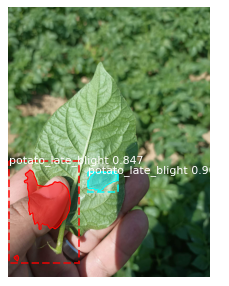

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
730
792
1210
887
1170
291
778


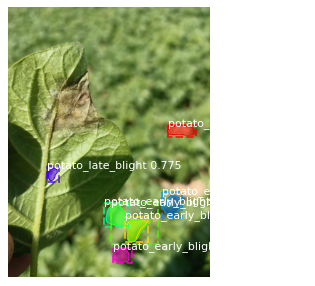

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  137.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
0
1149
355


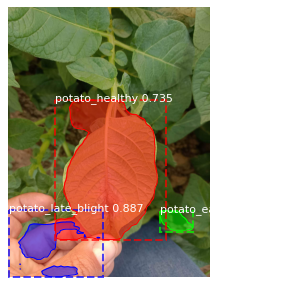

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  143.10000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
683
702
403


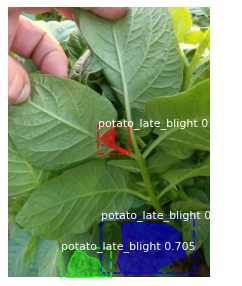

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
1033
548
529
602
886


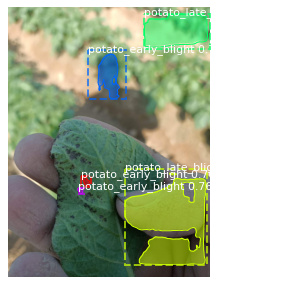

Processing 1 images
image                    shape: (2048, 1536, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.20000  float64
image_metas              shape: (1, 16)               min:    0.00000  max: 2048.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
813
989
1022


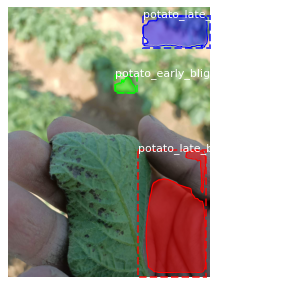

In [8]:
import skimage
import matplotlib.pyplot as plt

real_test_dir = r'\dataset\validate'
image_paths = []
for filename in os.listdir(real_test_dir):
    if os.path.splitext(filename)[1].lower() in ['.png', '.jpg', '.jpeg']:
        image_paths.append(os.path.join(real_test_dir, filename))

for image_path in image_paths:
    img = skimage.io.imread(image_path)
    img_arr = np.array(img)
    results = model.detect([img_arr], verbose=1)
    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], dataset.class_names,
                                 r['scores'], figsize=(5,5))